In [8]:
!pip install scikeras
!pip3 install -U imbalanced-learn

In [9]:
import numpy as np
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scikeras.wrappers import KerasClassifier #need wrapper to convert keras to sklearn metrics
from sklearn.model_selection import RepeatedKFold, cross_val_score
from keras.models import Sequential
from imblearn.under_sampling import RandomUnderSampler




In [10]:
url = 'https://raw.githubusercontent.com/rayfin-ucsd/CSE151AGroupProject/main/USGovtRevCollect_20041001_20231227.csv'
df = pd.read_csv(url)
df.drop_duplicates(inplace=True)
dfOriginal = df.copy()
df.info()
df['Record Date'] = pd.to_datetime(df['Record Date'])
record_date = df['Record Date'].dt
record_year = record_date.year
record_month = record_date.month
record_day = record_date.day
record_quarter = record_date.quarter

year_match = (record_year == df['Calendar Year']).all()
month_match = (record_month == df['Calendar Month Number']).all()
day_match = (record_day == df['Calendar Day Number']).all()
quarter_match = (record_quarter == df['Calendar Quarter Number']).all()
print("year match =", year_match)
print("month match =", month_match)
print("day match =", day_match)
print("quarter match =", quarter_match)
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81248 entries, 0 to 81247
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Record Date                      81248 non-null  object 
 1   Electronic Category Description  81248 non-null  object 
 2   Channel Type Description         81248 non-null  object 
 3   Tax Category Description         81248 non-null  object 
 4   Net Collections Amount           81248 non-null  float64
 5   Electronic Category ID           81248 non-null  int64  
 6   Channel Type ID                  81248 non-null  int64  
 7   Tax Category ID                  81248 non-null  int64  
 8   Source Line Number               81248 non-null  int64  
 9   Fiscal Year                      81248 non-null  int64  
 10  Fiscal Quarter Number            81248 non-null  int64  
 11  Calendar Year                    81248 non-null  int64  
 12  Calendar Quarter N

,Record Date,Electronic Category Description,Channel Type Description,Tax Category Description,Net Collections Amount,Electronic Category ID,Channel Type ID,Tax Category ID,Source Line Number,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number
0,2023-12-27,Non-Electronic,Mail,Non-Tax,7.269500e+02,4,2,1,1,2024,1,2023,4,12,27
1,2023-12-27,Electronic Settlement,Over-the-Counter (OTC),Non-Tax,2.431048e+05,3,1,1,2,2024,1,2023,4,12,27
2,2023-12-27,Non-Electronic,Over-the-Counter (OTC),Non-Tax,9.395110e+06,4,1,1,3,2024,1,2023,4,12,27
3,2023-12-27,Fully Electronic - FS,Over-the-Counter (OTC),IRS Non-Tax,4.824105e+04,2,1,2,4,2024,1,2023,4,12,27
4,2023-12-27,Fully Electronic - All,Bank,IRS Tax,2.905820e+03,1,5,3,5,2024,1,2023,4,12,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81243,2004-10-01,Fully Electronic - All,Bank,IRS Tax,4.838831e+09,1,5,3,12,2005,1,2004,4,10,1
81244,2004-10-01,Non-Electronic,Bank,Non-Tax,2.114361e+06,4,5,1,1,2005,1,2004,4,10,1
81245,2004-10-01,Fully Electronic - All,Internet,Non-Tax,1.183413e+07,1,3,1,2,2005,1,2004,4,10,1
81246,2004-10-01,Fully Electronic - FS,Over-the-Counter (OTC),Non-Tax,1.921165e+06,2,1,1,3,2005,1,2004,4,10,1


There is 'Record Date' in the data, and there are also 'Calendar Year, Month, Day, Quarter' respectively.  
After checking, they are the same, so one of them can be removed.

In [11]:
df_sorted = df.sort_values(by='Record Date')
df_sorted['Date Diff'] = df_sorted['Record Date'].diff().dt.days
date_diff = df_sorted['Date Diff'].value_counts().sort_index()
print(date_diff)

Date Diff
0.0    76414
1.0     3779
2.0       50
3.0      869
4.0      135
Name: count, dtype: int64


In [12]:
fiscal_date = df.groupby(['Fiscal Year', 'Fiscal Quarter Number']).size()
fiscal_date_unstack = fiscal_date.unstack(fill_value=0)
print(fiscal_date_unstack)
fiscal_date_std = fiscal_date.std()
print("Standard deviation =", fiscal_date_std)

Fiscal Quarter Number     1     2     3     4
Fiscal Year                                  
2005                   1093  1096  1219  1293
2006                   1219  1237  1281  1266
2007                   1258  1292  1364  1341
2008                   1253  1160  1195  1202
2009                   1129  1098  1149  1170
2010                   1101  1081  1128  1139
2011                   1146  1148  1198  1250
2012                   1181  1154  1177  1144
2013                   1064  1087  1181  1165
2014                   1107   995  1029  1040
2015                    993   977  1024  1049
2016                   1001   988  1024  1038
2017                    975   979   992   974
2018                    926   947   996   973
2019                    943   927   984   947
2020                    881   868   849   914
2021                    862   827   886   886
2022                    876   846   859   873
2023                    822   862   876   905
2024                    869     0 

 The federal government's fiscal year runs from October 1 to September 30.  
Through observation, we found that the standard deviation of the statiscal numbers in different fiscal quarters is not large  
which shows that the number of records in different fiscals is relatively evenly distributed  
we can use this data for analysis without cleaning

In [13]:
df.groupby('Electronic Category Description').size()

Electronic Category Description
Electronic Settlement     12466
Fully Electronic - All    31609
Fully Electronic - FS     14129
Non-Electronic            23044
dtype: int64

In [14]:
df.groupby('Channel Type Description').size()

Channel Type Description
Bank                      12443
Internet                  13911
Mail                      20345
Other                        66
Over-the-Counter (OTC)    34483
dtype: int64

In [15]:
df.groupby('Tax Category Description').size()

Tax Category Description
IRS Non-Tax    18545
IRS Tax        24843
Non-Tax        37860
dtype: int64

There are a few categories in these three strings 'Electronic Category Description', 'Channel Type Description', and 'Tax Category Description'  
We don't know how it contributes to our goals for the time being  
so we first assume that they are independent and use IDs

The dataset includes the columns "Channel Type ID", "Electronic Category ID", and "Tax Category ID", which seem to be label encoded versions of the columns "Channel Type Description", "Electronic Category Description", and "Tax Category Description", so we want to check whether these columns are the same and correspond with each other.

In [16]:
chUnique = df.drop_duplicates(subset=['Channel Type ID', 'Channel Type Description'], keep='first')[['Channel Type ID', 'Channel Type Description']].head()
chMap = dict(zip(chUnique['Channel Type Description'], chUnique['Channel Type ID']))

taxUnique = df.drop_duplicates(subset=['Tax Category ID', 'Tax Category Description'], keep='first')[['Tax Category ID', 'Tax Category Description']].head()
taxMap = dict(zip(taxUnique['Tax Category Description'], taxUnique['Tax Category ID']))

elecUnique = df.drop_duplicates(subset=['Electronic Category ID', 'Electronic Category Description'], keep='first')[['Electronic Category ID', 'Electronic Category Description']].head()
elecMap = dict(zip(elecUnique['Electronic Category Description'], elecUnique['Electronic Category ID']))

chMatched = (df['Channel Type Description'].apply(lambda x: chMap[x]) == df['Channel Type ID']).all()
taxMatched = (df['Tax Category Description'].apply(lambda x: taxMap[x]) == df['Tax Category ID']).all()
elecMatched = (df['Electronic Category Description'].apply(lambda x: elecMap[x]) == df['Electronic Category ID']).all()

print("Channel Type Matches", chMatched)
print("Tax Category Matches", taxMatched)
print("Electronic Category Matches", elecMatched)

Channel Type Matches True
Tax Category Matches True
Electronic Category Matches True


In [17]:
df.groupby('Source Line Number').size()

Source Line Number
1     4834
2     4834
3     4834
4     4834
5     4834
6     4834
7     4834
8     4834
9     4834
10    4834
11    4834
12    4828
13    4790
14    4465
15    3947
16    3336
17    2427
18    2026
19    1201
20     657
21     303
22      92
23       2
dtype: int64

// comments: Indicates the row of the corresponding table where the data point can be found.  
This data seems not stronly related to our goals  
If we want fewer features, maybe ignore it for now

In [18]:
df_processed = df.copy()
min_date = df_processed['Record Date'].min()
df_processed['Record Date Discretized'] = (df_processed['Record Date'] - min_date).dt.days
df_processed.drop(['Record Date', 'Source Line Number', 'Electronic Category Description', 'Channel Type Description', 'Tax Category Description'], axis=1, inplace=True)
df_processed

,Net Collections Amount,Electronic Category ID,Channel Type ID,Tax Category ID,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number,Record Date Discretized
0,7.269500e+02,4,2,1,2024,1,2023,4,12,27,7026
1,2.431048e+05,3,1,1,2024,1,2023,4,12,27,7026
2,9.395110e+06,4,1,1,2024,1,2023,4,12,27,7026
3,4.824105e+04,2,1,2,2024,1,2023,4,12,27,7026
4,2.905820e+03,1,5,3,2024,1,2023,4,12,27,7026
...,...,...,...,...,...,...,...,...,...,...,...
81243,4.838831e+09,1,5,3,2005,1,2004,4,10,1,0
81244,2.114361e+06,4,5,1,2005,1,2004,4,10,1,0
81245,1.183413e+07,1,3,1,2005,1,2004,4,10,1,0
81246,1.921165e+06,2,1,1,2005,1,2004,4,10,1,0


We do the following preprocessing:
1. Delete 'Source Line Number', 'Electronic Category Description', 'Channel Type Description', 'Tax Category Description'
2. Discretize the Record Date into an integer, because we guess that the target has a polynomial relationship with this number
3. Remove the string class and keep only the encoded integers
We guessed that fiscal quarter would be an interesting feature, so we kept the information  
For record date, we don’t know whether quarter will be related to goals, so we keep the year, month, day, quarter and discretized integers.  

But because they are not independent of each other, during actual analysis, there are several options:
1. Discretized integers
2. year, month, day
3. year, quarter
4. Others

In [19]:
df_processed.to_csv('data_processed.csv', index=True)

In [20]:
#81248 rows of data and 15 columns
df = df_processed
df.shape

(81248, 11)

In [21]:
df.dtypes

Net Collections Amount     float64
Electronic Category ID       int64
Channel Type ID              int64
Tax Category ID              int64
Fiscal Year                  int64
Fiscal Quarter Number        int64
Calendar Year                int64
Calendar Quarter Number      int64
Calendar Month Number        int64
Calendar Day Number          int64
Record Date Discretized      int64
dtype: object

In [22]:
#Converting Record Date column to datetime objects.
df['Record Date Discretized'] = pd.to_datetime(df['Record Date Discretized'])

In [23]:
df

,Net Collections Amount,Electronic Category ID,Channel Type ID,Tax Category ID,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number,Record Date Discretized
0,7.269500e+02,4,2,1,2024,1,2023,4,12,27,1970-01-01 00:00:00.000007026
1,2.431048e+05,3,1,1,2024,1,2023,4,12,27,1970-01-01 00:00:00.000007026
2,9.395110e+06,4,1,1,2024,1,2023,4,12,27,1970-01-01 00:00:00.000007026
3,4.824105e+04,2,1,2,2024,1,2023,4,12,27,1970-01-01 00:00:00.000007026
4,2.905820e+03,1,5,3,2024,1,2023,4,12,27,1970-01-01 00:00:00.000007026
...,...,...,...,...,...,...,...,...,...,...,...
81243,4.838831e+09,1,5,3,2005,1,2004,4,10,1,1970-01-01 00:00:00.000000000
81244,2.114361e+06,4,5,1,2005,1,2004,4,10,1,1970-01-01 00:00:00.000000000
81245,1.183413e+07,1,3,1,2005,1,2004,4,10,1,1970-01-01 00:00:00.000000000
81246,1.921165e+06,2,1,1,2005,1,2004,4,10,1,1970-01-01 00:00:00.000000000


In [24]:
df['Electronic Category ID'].unique()

array([4, 3, 2, 1], dtype=int64)

In [25]:
df['Channel Type ID'].unique()

array([2, 1, 5, 3, 7], dtype=int64)

In [26]:
df['Tax Category ID'].unique()

array([1, 2, 3], dtype=int64)

In [27]:
df['Fiscal Year'].unique()

array([2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014,
       2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005], dtype=int64)

In [28]:
df['Calendar Year'].unique()

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013,
       2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004], dtype=int64)

In [29]:
#No missing data
df.isnull().values.any()

False

In [30]:
#4834 unique days of records
df.groupby('Record Date Discretized').count()

,Net Collections Amount,Electronic Category ID,Channel Type ID,Tax Category ID,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number
Record Date Discretized,,,,,,,,,,
1970-01-01 00:00:00.000000000,17,17,17,17,17,17,17,17,17,17
1970-01-01 00:00:00.000000003,16,16,16,16,16,16,16,16,16,16
1970-01-01 00:00:00.000000004,17,17,17,17,17,17,17,17,17,17
1970-01-01 00:00:00.000000005,17,17,17,17,17,17,17,17,17,17
1970-01-01 00:00:00.000000006,16,16,16,16,16,16,16,16,16,16
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000007019,15,15,15,15,15,15,15,15,15,15
1970-01-01 00:00:00.000007020,14,14,14,14,14,14,14,14,14,14
1970-01-01 00:00:00.000007021,15,15,15,15,15,15,15,15,15,15


In [31]:
df

,Net Collections Amount,Electronic Category ID,Channel Type ID,Tax Category ID,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number,Record Date Discretized
0,7.269500e+02,4,2,1,2024,1,2023,4,12,27,1970-01-01 00:00:00.000007026
1,2.431048e+05,3,1,1,2024,1,2023,4,12,27,1970-01-01 00:00:00.000007026
2,9.395110e+06,4,1,1,2024,1,2023,4,12,27,1970-01-01 00:00:00.000007026
3,4.824105e+04,2,1,2,2024,1,2023,4,12,27,1970-01-01 00:00:00.000007026
4,2.905820e+03,1,5,3,2024,1,2023,4,12,27,1970-01-01 00:00:00.000007026
...,...,...,...,...,...,...,...,...,...,...,...
81243,4.838831e+09,1,5,3,2005,1,2004,4,10,1,1970-01-01 00:00:00.000000000
81244,2.114361e+06,4,5,1,2005,1,2004,4,10,1,1970-01-01 00:00:00.000000000
81245,1.183413e+07,1,3,1,2005,1,2004,4,10,1,1970-01-01 00:00:00.000000000
81246,1.921165e+06,2,1,1,2005,1,2004,4,10,1,1970-01-01 00:00:00.000000000


In [32]:
df.groupby('Fiscal Year').count()[['Record Date Discretized']].rename(columns = {'Record Date': 'Count'})

,Record Date Discretized
Fiscal Year,
2005,4701
2006,5003
2007,5255
2008,4810
2009,4546
2010,4449
2011,4742
2012,4656
2013,4497


In [33]:
df.groupby('Fiscal Year')[['Net Collections Amount']].sum()

,Net Collections Amount
Fiscal Year,
2005,2.651425e+12
2006,2.921450e+12
2007,3.109482e+12
2008,3.191062e+12
2009,2.855280e+12
2010,2.935275e+12
2011,3.062801e+12
2012,3.158251e+12
2013,3.562188e+12


In [34]:
df.groupby('Electronic Category ID')[['Net Collections Amount']].sum()

,Net Collections Amount
Electronic Category ID,
1,6.248116e+13
2,6.513066e+11
3,5.683999e+12
4,4.469666e+12


In [35]:
df.groupby('Channel Type ID')[['Net Collections Amount']].sum()

,Net Collections Amount
Channel Type ID,
1,2.746536e+12
2,8.189791e+12
3,4.660688e+13
5,1.574290e+13
7,2.569657e+07


In [36]:
df.groupby('Tax Category ID')[['Net Collections Amount']].sum()

,Net Collections Amount
Tax Category ID,
1,1.217764e+13
2,2.529981e+09
3,6.110596e+13


<Axes: >

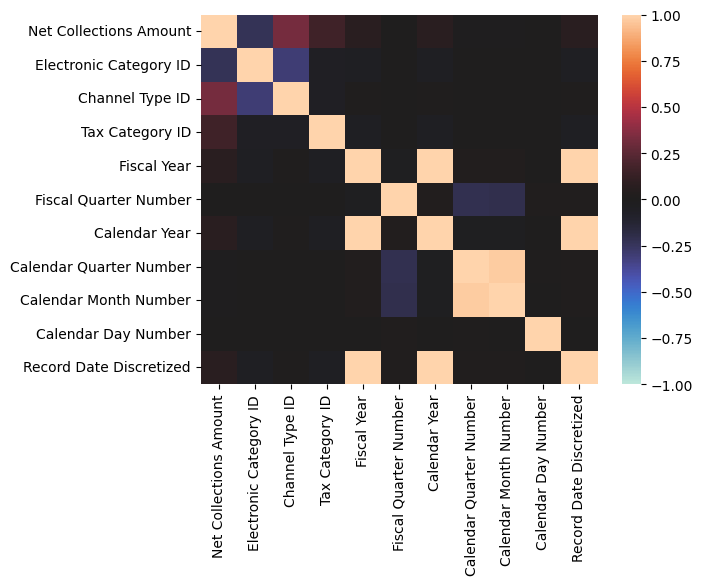

In [37]:

#categoricalCols = ['Tax Category Description', 'Channel Type Description', 'Electronic Category Description']


labelConverted = df.apply(lambda x: LabelEncoder().fit_transform(df[x.name]))

sns.heatmap(labelConverted.corr(), vmin=-1, vmax=1, center=0)

<Axes: xlabel='Fiscal Year', ylabel='Net Collections Amount'>

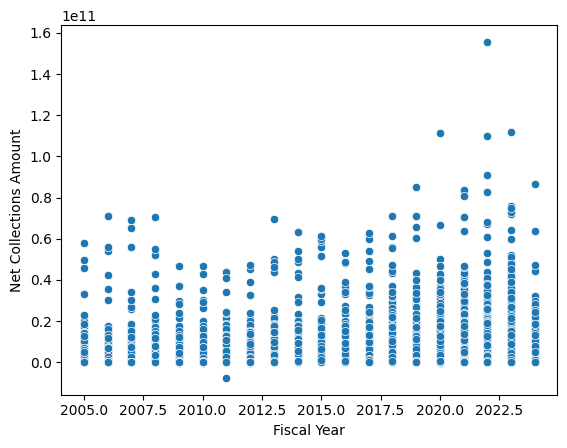

In [38]:
sns.scatterplot(x=df['Fiscal Year'], y=df['Net Collections Amount'])

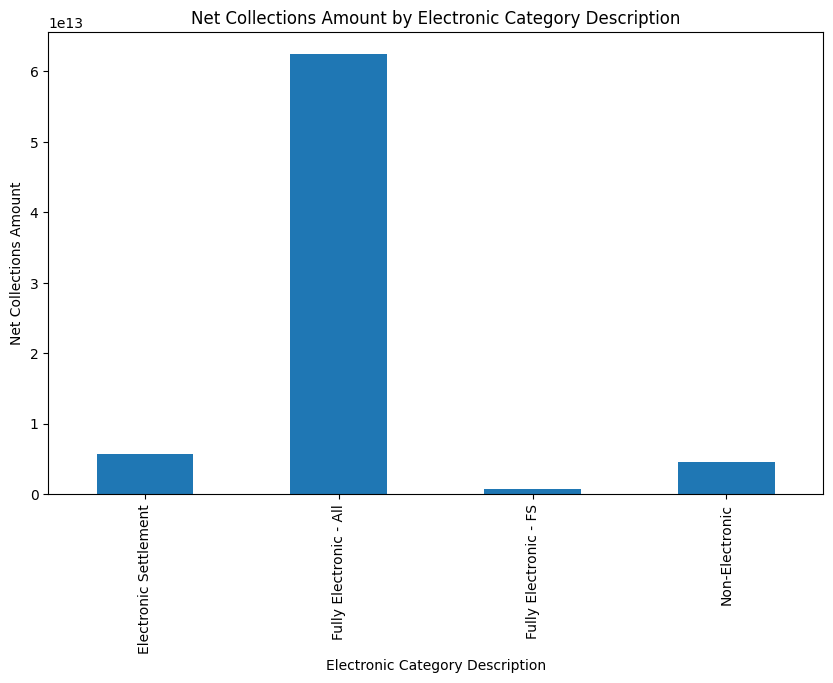

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
dfOriginal.groupby('Electronic Category Description')['Net Collections Amount'].sum().plot(kind='bar')
plt.title('Net Collections Amount by Electronic Category Description')
plt.xlabel('Electronic Category Description')
plt.ylabel('Net Collections Amount')
plt.show()

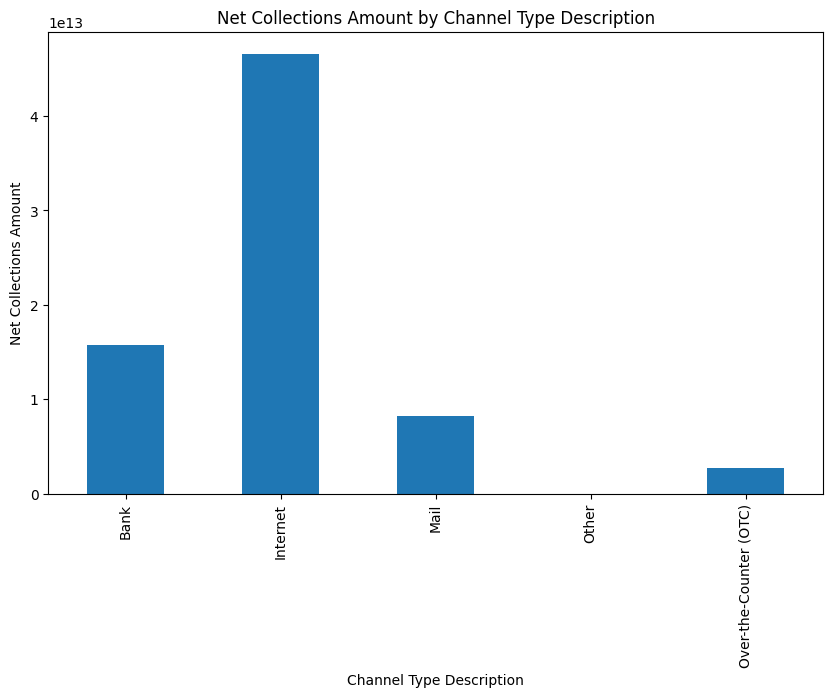

In [40]:
plt.figure(figsize=(10, 6))
dfOriginal.groupby('Channel Type Description')['Net Collections Amount'].sum().plot(kind='bar')
plt.title('Net Collections Amount by Channel Type Description')
plt.xlabel('Channel Type Description')
plt.ylabel('Net Collections Amount')
plt.show()

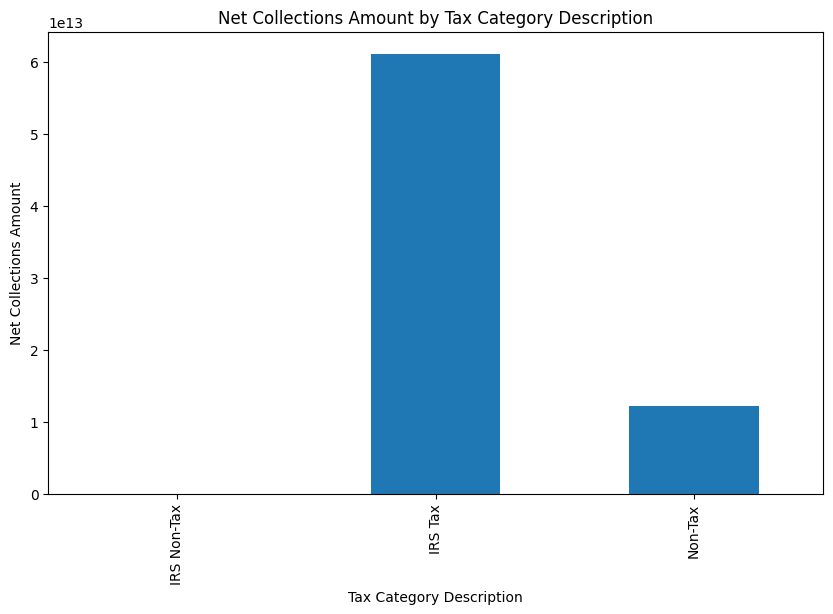

In [41]:
plt.figure(figsize=(10, 6))
dfOriginal.groupby('Tax Category Description')['Net Collections Amount'].sum().plot(kind='bar')
plt.title('Net Collections Amount by Tax Category Description')
plt.xlabel('Tax Category Description')
plt.ylabel('Net Collections Amount')
plt.show()


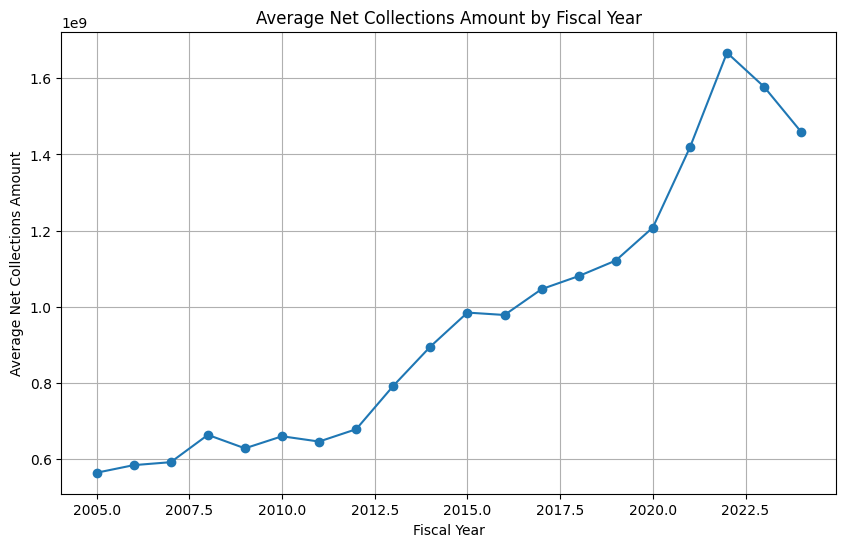

In [42]:
plt.figure(figsize=(10, 6))
dfOriginal.groupby('Fiscal Year')['Net Collections Amount'].mean().plot(kind='line', marker='o')
plt.title('Average Net Collections Amount by Fiscal Year')
plt.xlabel('Fiscal Year')
plt.ylabel('Average Net Collections Amount')
plt.grid(True)
plt.show()

# Beginning Of Milestone 3

In [43]:
#We don't necessarily have to normalize our data here.
#First, convert DataTime64 object to Float64 so we can use it in regression properly
df['Record Date Discretized'] = df['Record Date Discretized'].values.astype("float64")


#Do one-hot-encoding on IDs for easier data analytics



onehot = OneHotEncoder()
to_encode = ['Electronic Category ID', 'Channel Type ID', 'Tax Category ID']
one_hot_encoded = onehot.fit_transform(df[to_encode])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=onehot.get_feature_names_out(to_encode))
df_encoded = df.drop(to_encode, axis=1) #keep original df just in case
df_encoded = pd.concat([df_encoded, one_hot_encoded_df], axis=1)

df_encoded

,Net Collections Amount,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number,Record Date Discretized,Electronic Category ID_1,Electronic Category ID_2,Electronic Category ID_3,Electronic Category ID_4,Channel Type ID_1,Channel Type ID_2,Channel Type ID_3,Channel Type ID_5,Channel Type ID_7,Tax Category ID_1,Tax Category ID_2,Tax Category ID_3
0,7.269500e+02,2024,1,2023,4,12,27,7026.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.431048e+05,2024,1,2023,4,12,27,7026.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,9.395110e+06,2024,1,2023,4,12,27,7026.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.824105e+04,2024,1,2023,4,12,27,7026.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.905820e+03,2024,1,2023,4,12,27,7026.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81243,4.838831e+09,2005,1,2004,4,10,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
81244,2.114361e+06,2005,1,2004,4,10,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
81245,1.183413e+07,2005,1,2004,4,10,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
81246,1.921165e+06,2005,1,2004,4,10,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


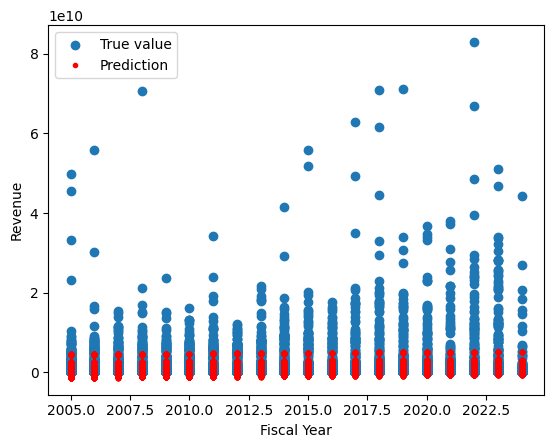

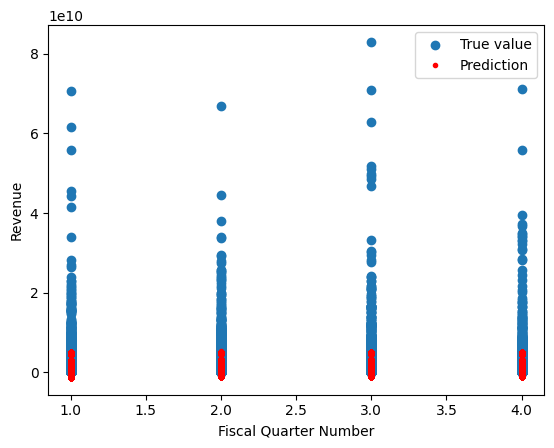

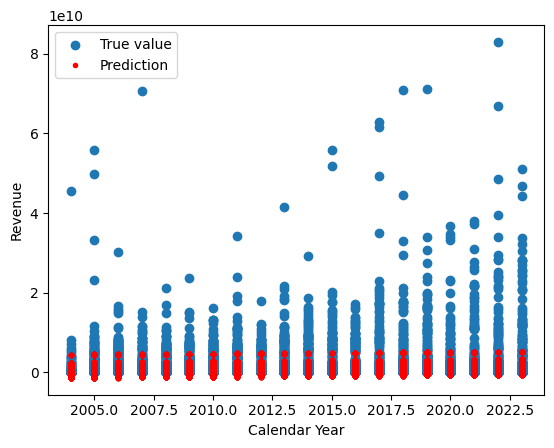

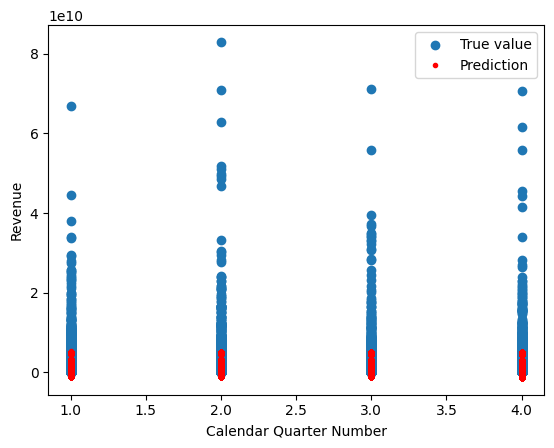

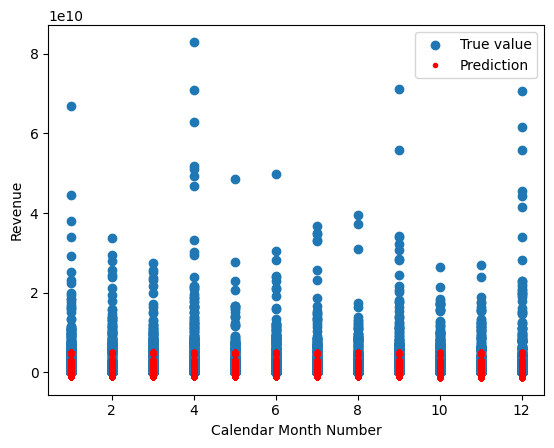

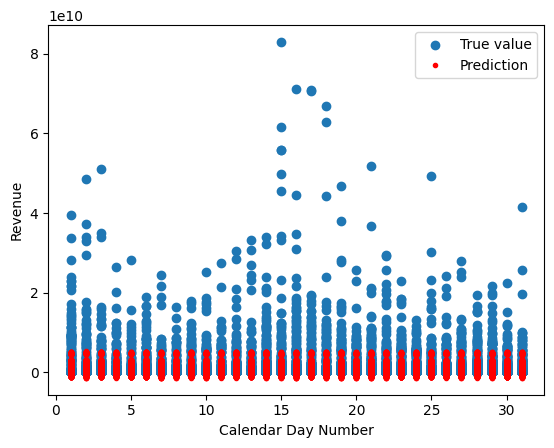

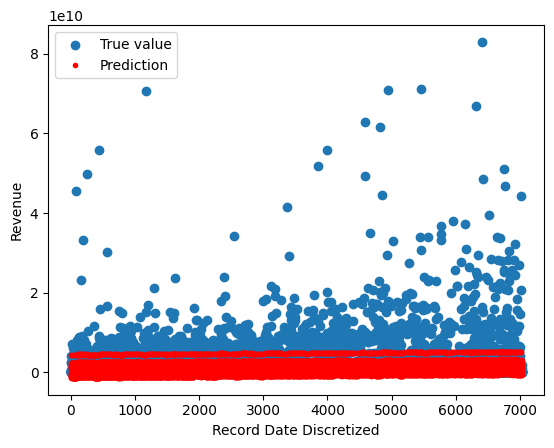

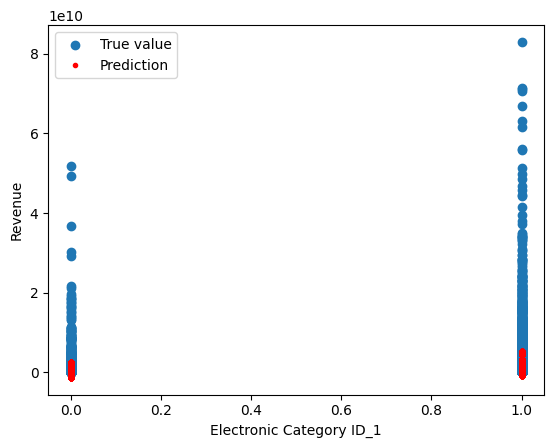

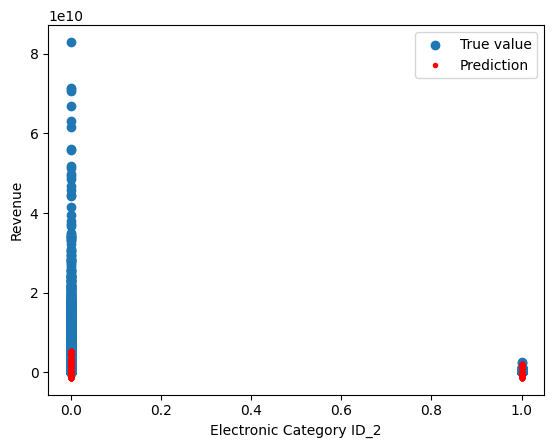

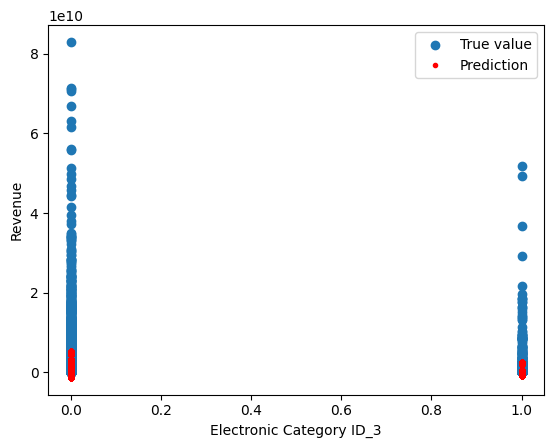

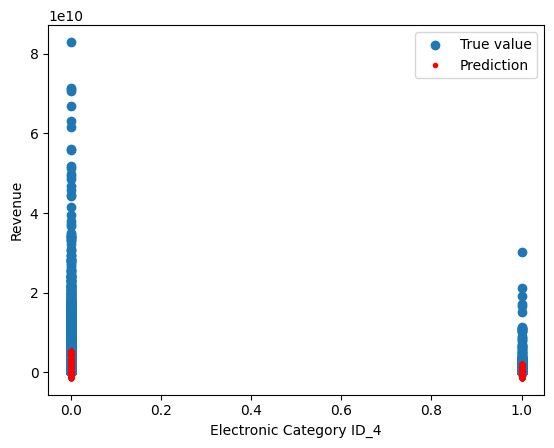

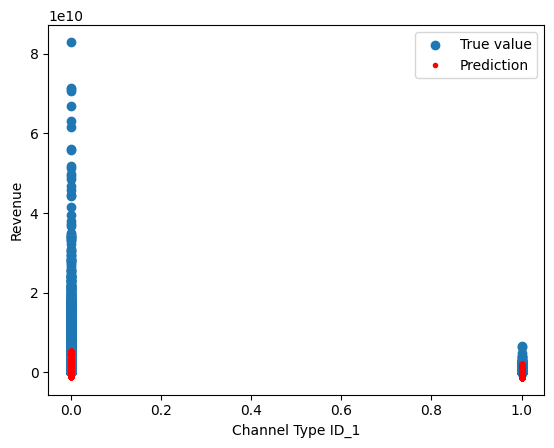

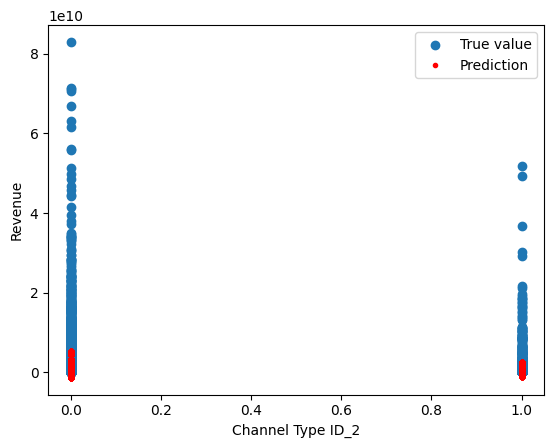

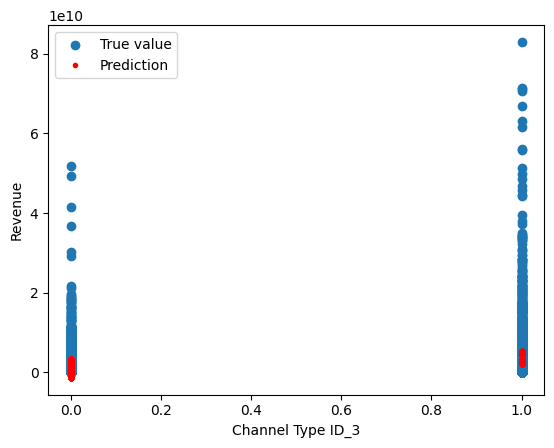

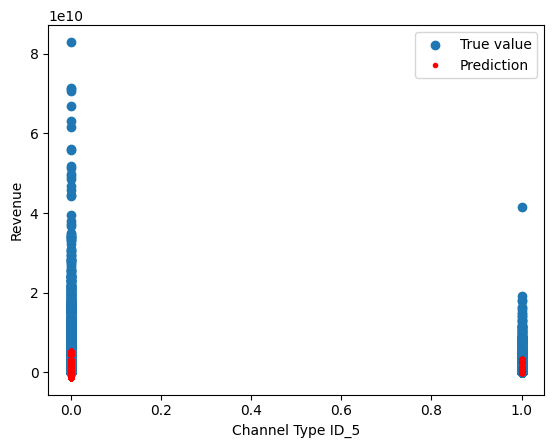

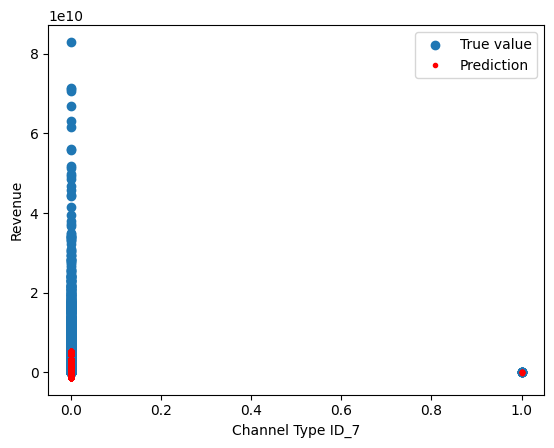

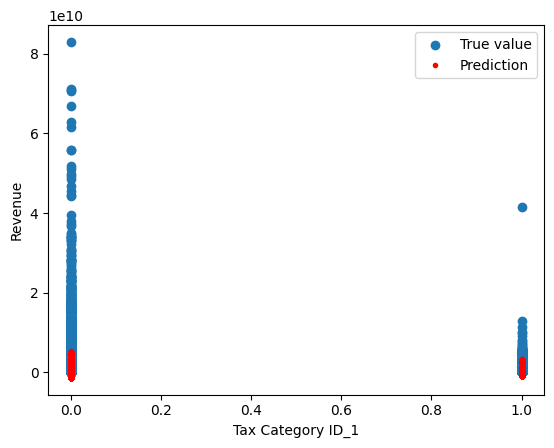

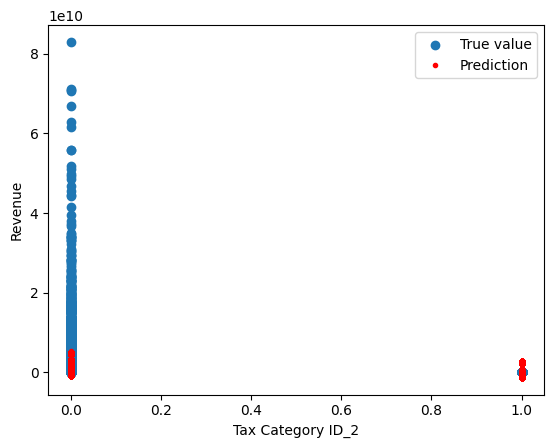

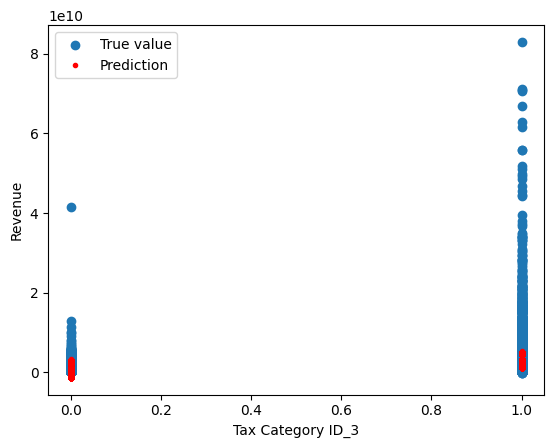

In [44]:
#Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(['Net Collections Amount'], axis=1), df_encoded['Net Collections Amount'], test_size=0.2, random_state=21)

reg = LinearRegression()
regmodel = reg.fit(X_train, y_train)
yhat_train = reg.predict(X_train)
yhat_test = reg.predict(X_test)

for feature in X_train.columns:
  plt.scatter(X_test[feature], y_test, label="True value")
  plt.plot(X_test[feature], yhat_test, 'r.', label='Prediction')
  plt.legend()
  plt.xlabel(feature)
  plt.ylabel('Revenue')
  plt.show()



In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_train = mean_squared_error(y_train, yhat_train)
mse_test = mean_squared_error(y_test, yhat_test)

print('Training MSE: ', mse_train)
print('Test MSE: ', mse_test)

mae_train = mean_absolute_error(y_train, yhat_train)
mae_test = mean_absolute_error(y_test, yhat_test)

print('Training MAE: ', mae_train)
print('Test MAE: ', mae_test)

Training MSE:  9.921680122975543e+18
Test MSE:  8.863121770208695e+18
Training MAE:  1363190931.6938503
Test MAE:  1346315683.6159906


There seems to be underfitting since the error is very high for both the testing and training set. The model seems to be too simple to accurately predict the target.

For the future models, we could try turning this into a classification problem by encoding the Net Collection Amount into ordinal categories based on the range of values they fall under. By doing this, we could use perceptrons and neural nets as our next model.

In [46]:
import pandas as pd

df_encoded_sorted = df_encoded.sort_values(by=['Net Collections Amount'])

df_encoded_sorted['Net Collections Amount Rank'] = pd.qcut(df_encoded_sorted['Net Collections Amount'], 5, labels=False)

df_encoded_classification = df_encoded_sorted.drop(columns=['Net Collections Amount'])




If we decided to do a classification model later, we can use this rank as our target.

# Milestone 4 Begins Here!

In [101]:
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler


y_raw = df_encoded['Net Collections Amount']

df_encoded_classification['Fiscal Year'] = StandardScaler().fit_transform(df_encoded['Fiscal Year'].to_numpy().reshape(-1, 1))
df_encoded_classification['Record Date Discretized'] = StandardScaler().fit_transform(df_encoded['Record Date Discretized'].to_numpy().reshape(-1, 1))

# Original preprocessing using quantiles did not yield good results, trying uniform discretization this time 
disc = KBinsDiscretizer(n_bins=15, encode='onehot-dense', strategy='uniform')
y_class = disc.fit_transform(y_raw.to_numpy().reshape(-1, 1))

print(y_class.shape)

x_sampled, y_sampled = RandomUnderSampler(replacement=True, random_state=20, sampling_strategy='majority').fit_resample(df_encoded_classification.drop(columns=['Net Collections Amount Rank']), y_class)

print(np.sum(y_sampled[:,1:14]))

x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(x_sampled, y_sampled, test_size=0.1, random_state=20)
print(x_train_class.shape, y_train_class.shape)

(81248, 15)
5660
(5094, 19) (5094, 12)


c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [102]:
from keras.models import Sequential
from keras.layers import Dense

modelUnits = [128, 128, 64, 64, y_train_class.shape[1]]
activationFxn = 'relu'

classifier = Sequential([
  Dense(units = modelUnits[0], activation=activationFxn, input_dim=df_encoded_classification.shape[1]-1),
  Dense(units = modelUnits[1], activation=activationFxn),
  #Dense(units = modelUnits[2], activation=activationFxn),
  #Dense(units = modelUnits[3], activation=activationFxn),
  Dense(units = modelUnits[4], activation='softmax')
])

classifier.compile(optimizer='adam', loss='categorical_crossentropy')

c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [103]:
hist = classifier.fit(x=x_train_class, y=y_train_class, batch_size=1, epochs=10, verbose=1, validation_split=0.1)


Epoch 1/10
4584/4584 ━━━━━━━━━━━━━━━━━━━━ 3s 604us/step - loss: 9.1820 - val_loss: 2.1024
Epoch 2/10
4584/4584 ━━━━━━━━━━━━━━━━━━━━ 3s 651us/step - loss: 1.0626 - val_loss: 0.6619
Epoch 3/10
4584/4584 ━━━━━━━━━━━━━━━━━━━━ 6s 728us/step - loss: 0.6449 - val_loss: 0.5638
Epoch 4/10
4584/4584 ━━━━━━━━━━━━━━━━━━━━ 3s 715us/step - loss: 0.6186 - val_loss: 0.5566
Epoch 5/10
4584/4584 ━━━━━━━━━━━━━━━━━━━━ 3s 734us/step - loss: 0.5651 - val_loss: 0.5577
Epoch 6/10
4584/4584 ━━━━━━━━━━━━━━━━━━━━ 3s 734us/step - loss: 0.5835 - val_loss: 0.5580
Epoch 7/10
4584/4584 ━━━━━━━━━━━━━━━━━━━━ 3s 735us/step - loss: 0.6067 - val_loss: 0.5568
Epoch 8/10
4584/4584 ━━━━━━━━━━━━━━━━━━━━ 3s 745us/step - loss: 0.6231 - val_loss: 0.5571
Epoch 9/10
4584/4584 ━━━━━━━━━━━━━━━━━━━━ 3s 725us/step - loss: 0.5961 - val_loss: 0.5588
Epoch 10/10
4584/4584 ━━━━━━━━━━━━━━━━━━━━ 3s 725us/step - loss: 0.5817 - val_loss: 0.5593


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[1]
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
Test               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.83      1.00      0.91       472
           2       0.00      0.00      0.00        68
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         3

   micro avg       0.83      0.84      0.84       560
   macro avg       0.17      0.20      0.18       560
weighted avg       0.70      0.84      0.77       560

Train               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.85      1.00      0.92      4335
           2       0.00      0.00      0.00       491
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00        54

   micro avg       0.85      0.86      0.86      5026
   macro avg       0.17      0.20

c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

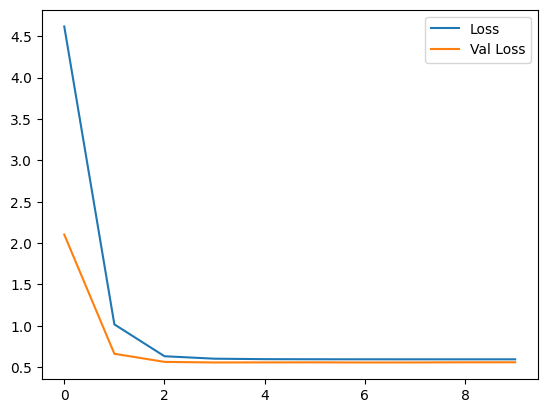

In [104]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report
y_test_raw = classifier.predict(x_test_class)
y_test_class_pred = np.argmax(y_test_raw, axis=1)
print(np.unique(y_test_class_pred))

y_train_class_pred = np.argmax(classifier.predict(x_train_class), axis=1)

print("Test", classification_report(y_true=np.asarray(np.argmax(y_test_class, axis=1)), y_pred=np.asarray(y_test_class_pred), labels=np.arange(5)))

print("Train", classification_report(y_true=np.asarray(np.argmax(y_train_class, axis=1)), y_pred=np.asarray(y_train_class_pred), labels=np.arange(5)))

plt.plot(np.arange(len(hist.history['loss'])), hist.history['loss'], label="Loss")
plt.plot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label="Val Loss")
plt.legend()
plt.show() 

In [ ]:
# Let's try a neural network. We are classifying our values as these ordinal categories:
df_encoded_classification['Net Collections Amount Rank'].value_counts()
#which are 0, 1, 2, 3, and 4.

# This is a multi-class problem, so we should use categorical crossentropy loss.
# Joseph is implementing a neural network classifier like the one from HW3.





#Try k-fold cross val after hyperparameter tuning's done.
#use: k_fold_model = k_fold_cross_val(input_model with best parameters)

def k_fold_cross_val(input_model):
  converted_classifier = KerasClassifier(model=input_model, classifier="adam", epochs=10, batch_size=100, verbose=0) # before submitting please set verbose = 0, and rerun. If not grading will be no bueno!
  kfold = RepeatedKFold(n_splits = 5, n_repeats = 5)
  results = cross_val_score(converted_classifier, X_train, y_train, cv=kfold, n_jobs = 1)
  return  results

#print(k_fold_cross_val(model))